# Network Science - Assignment 1

### About the dataset

This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict

In [2]:
file_path = 'datasets/soc-sign-bitcoinotc-short.csv'
data = pd.read_csv(file_path)

data.head()

,Source,Destination,Weight,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


## Answer 1

### a) Adjacency Matrix and Edge List

In [3]:
# Extracting unique nodes
nodes = np.unique(data[['Source', 'Destination']].values)
num_nodes = len(nodes)
print("Total no of nodes in the network are:", num_nodes)

Total no of nodes in the network are: 393


In [4]:
# Creating a mapping for nodes to indices
node_to_index = {node: idx for idx, node in enumerate(nodes)}

# Initializing the adjacency matrix
adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

# Populate the adjacency matrix
for _, row in data.iterrows():
    i, j = node_to_index[row['Source']], node_to_index[row['Destination']]
    adjacency_matrix[i, j] = row['Weight']  # Assuming weights are important
    
adjacency_matrix

array([[0, 8, 0, ..., 0, 0, 0],
       [8, 0, 8, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
# Creating edge list from the data
edge_list = data[['Source', 'Destination']].values
print("Total no of edges in the network are:", len(edge_list))
edge_list

Total no of edges in the network are: 1554


array([[  6,   2],
       [  6,   5],
       [  1,  15],
       ...,
       [198, 457],
       [457, 198],
       [198, 421]], dtype=int64)

### b) Visualizing the network

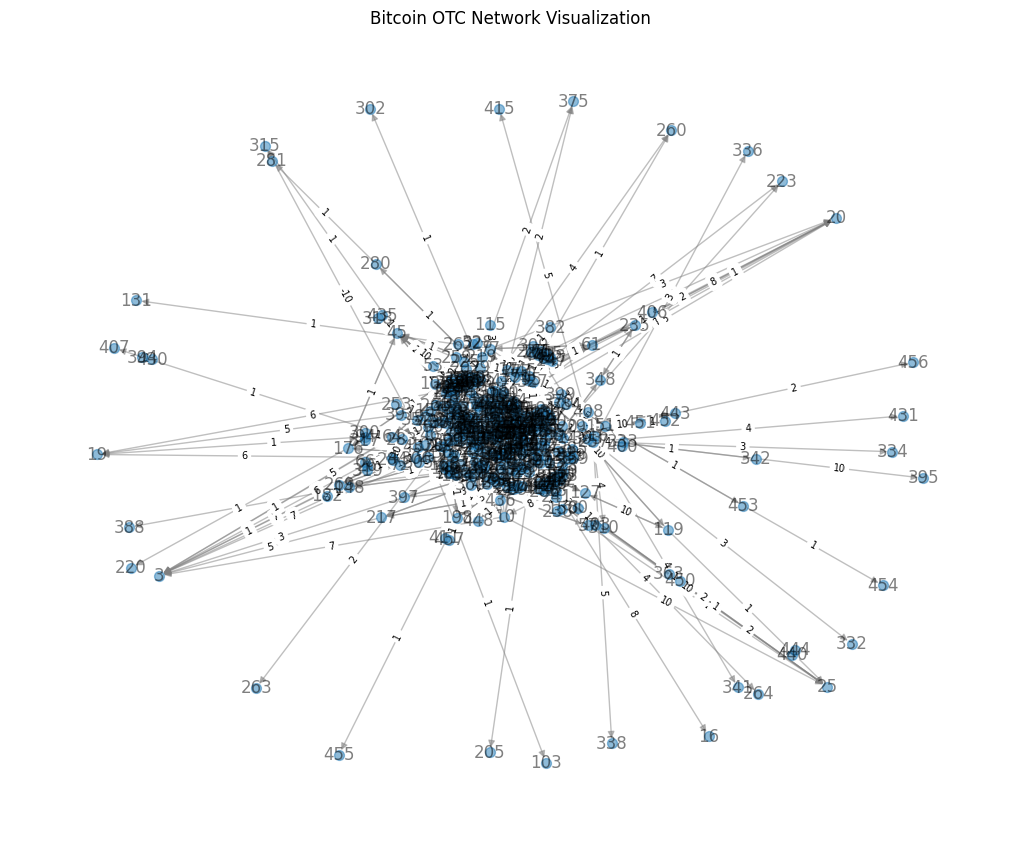

In [6]:
G = nx.from_pandas_edgelist(data, 'Source', 'Destination', ['Weight', 'Timestamp'], create_using=nx.DiGraph())

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=50, edge_color='gray', alpha=0.5)
edge_labels = nx.get_edge_attributes(G, 'Weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title('Bitcoin OTC Network Visualization')
plt.show()

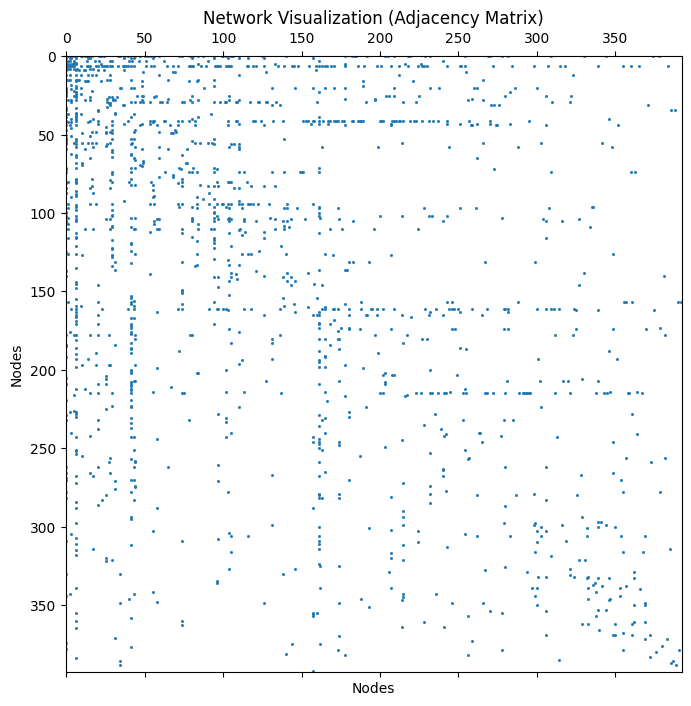

In [7]:
plt.figure(figsize=(10, 8))
plt.spy(adjacency_matrix, markersize=1)
plt.title('Network Visualization (Adjacency Matrix)')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

### Cytoscape Visualization

![Cytoscape](images/q1(b).png)

### c) Sparseness of the network

In [8]:
# Sparseness is calculated as the number of zero entries divided by the total number of entries
total_entries = num_nodes ** 2
nonzero_entries = np.count_nonzero(adjacency_matrix)
zero_entries = total_entries - nonzero_entries
sparseness = zero_entries / total_entries

print("The sparseness of the network is: ", sparseness)

The sparseness of the network is:  0.989938426276635


### Network Sparseness

Network sparseness is a metric used to quantify the lack of connections in a network relative to the maximum possible number of connections. In graph theory, a network is composed of nodes (or vertices) and edges (or links) that connect pairs of nodes. The sparseness of a network is essentially the complement of network density, which measures the fraction of potential connections in the network that are actually realized.

This gives us an intuitive measure of how "empty" a network is, indicating the extent to which nodes in the network are disconnected from each other.

### Overview of 0.98 Sparseness Value

A sparseness value of 0.98 signals a very sparse network. This implies that only 2% of the possible connections between nodes are present, showing that the network's nodes are generally isolated or form loosely connected clusters. 

In practical terms, for a network with a sparseness value of 0.98, it suggests that, on average, nodes have very few connections to other nodes. This level of sparseness is typical of many real-world networks (e.g., social networks, the Internet, biological networks), where connections are selective and most nodes are not directly connected to many others, often resulting in a structure characterized by a large number of small, disconnected groups or a distribution of node degrees that has a long tail.


### d) Average degree of the network

In [9]:
# Average degree <k> is the average number of edges per node
# For undirected graphs, <k> = 2 * E / N, where E is the number of edges and N is the number of nodes
num_edges = len(edge_list)
average_degree = 2 * num_edges / num_nodes

print("The average degree <k> of the graph is ",average_degree)

The average degree <k> of the graph is  7.908396946564886


### e) Plotting the ‘scaled degree distribution’ of the network

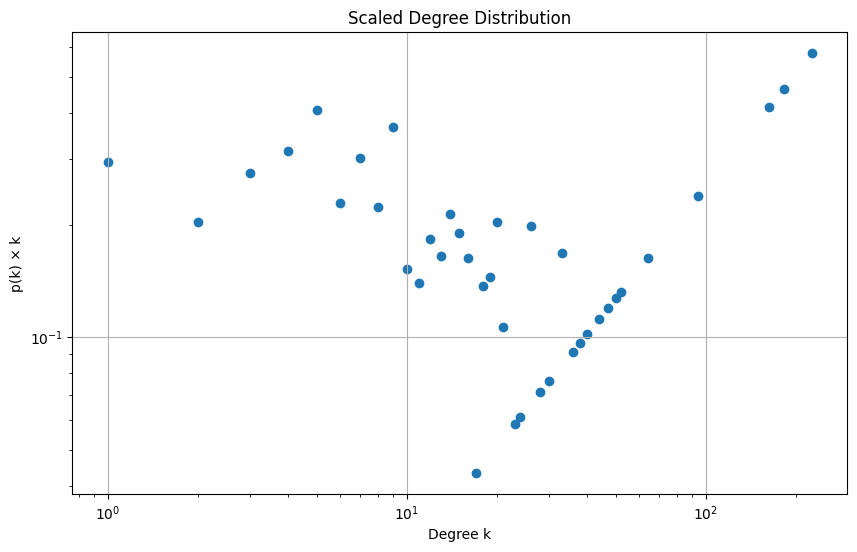

In [10]:
# Degree of each node is the sum of its connections (rows or columns of adjacency matrix)

# Calculated degree of each node
degrees = np.sum(adjacency_matrix, axis=0)  # Summed across columns

# Calculated degree distribution
unique_degrees, counts = np.unique(degrees, return_counts=True)
pk = counts / num_nodes  # Probability of each degree

# Plotted the scaled degree distribution, pk × k
plt.figure(figsize=(10, 6))
plt.scatter(unique_degrees, pk * unique_degrees)
plt.xlabel('Degree k')
plt.ylabel('p(k) × k')
plt.title('Scaled Degree Distribution')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


### f) Computing the average path length, diameter and the average clustering coefficient

In [11]:
# Breadth-First Search (BFS)

from collections import deque

def bfs(adj_matrix, start_node):
    num_nodes = len(adj_matrix)
    visited = [False] * num_nodes
    distance = [0] * num_nodes
    queue = deque([start_node])
    visited[start_node] = True

    while queue:
        current = queue.popleft()

        for neighbor in range(num_nodes):
            if adj_matrix[current][neighbor] != 0 and not visited[neighbor]:
                queue.append(neighbor)
                visited[neighbor] = True
                distance[neighbor] = distance[current] + 1

    return distance

In [12]:
# Computed Average Path Length and Diameter
total_distance = 0
max_distance = 0
num_paths = 0

for node in range(num_nodes):
    distances = bfs(adjacency_matrix, node)
    for dist in distances:
        if dist > 0:  # Ignored zero distances (self-distances)
            total_distance += dist
            max_distance = max(max_distance, dist)
            num_paths += 1

average_path_length = total_distance / num_paths
diameter = max_distance

print("The average path length of the network is:", average_path_length)
print("The diameter of the network is:", diameter)

The average path length of the network is: 3.376412665629136
The diameter of the network is: 8


In [13]:
# Calculated the average clustering coefficient
def average_clustering_coefficient(adj_matrix):
    num_nodes = adj_matrix.shape[0]
    clustering_coefficients = []

    for i in range(num_nodes):
        neighbors = np.nonzero(adj_matrix[i])[0]
        if len(neighbors) < 2:
            clustering_coefficients.append(0)
        else:
            # Counted the number of edges between neighbors
            edges_between_neighbors = sum([adj_matrix[n, m] for n in neighbors for m in neighbors if n != m]) // 2
            k_i = len(neighbors)
            clustering_coefficient = (2 * edges_between_neighbors) / (k_i * (k_i - 1))
            clustering_coefficients.append(clustering_coefficient)

    return np.mean(clustering_coefficients)

acc = average_clustering_coefficient(adjacency_matrix)
print("The average clustering coefficient of the network is ", acc)

The average clustering coefficient of the network is  0.28493315619507725


## Answer 2

In [14]:
# Calculated in-degree and out-degree for each node
in_degrees = {}
out_degrees = {}

for _, row in data.iterrows():
    source, destination = row['Source'], row['Destination']

    # Updated the out-degree for source
    if source in out_degrees:
        out_degrees[source] += 1
    else:
        out_degrees[source] = 1

    # Updated the in-degree for destination
    if destination in in_degrees:
        in_degrees[destination] += 1
    else:
        in_degrees[destination] = 1

# Ensured all nodes appear in both in-degrees and out-degrees dictionary
all_nodes = set(in_degrees).union(set(out_degrees))
for node in all_nodes:
    in_degrees.setdefault(node, 0)
    out_degrees.setdefault(node, 0)

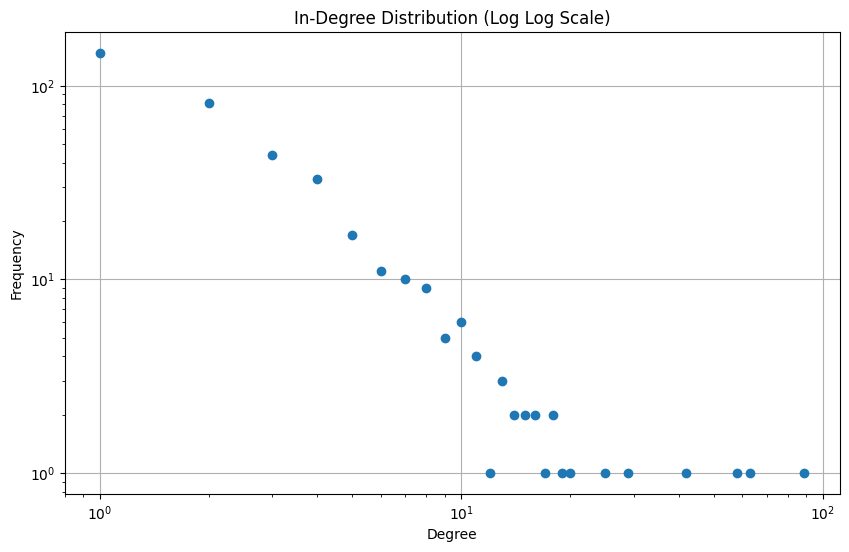

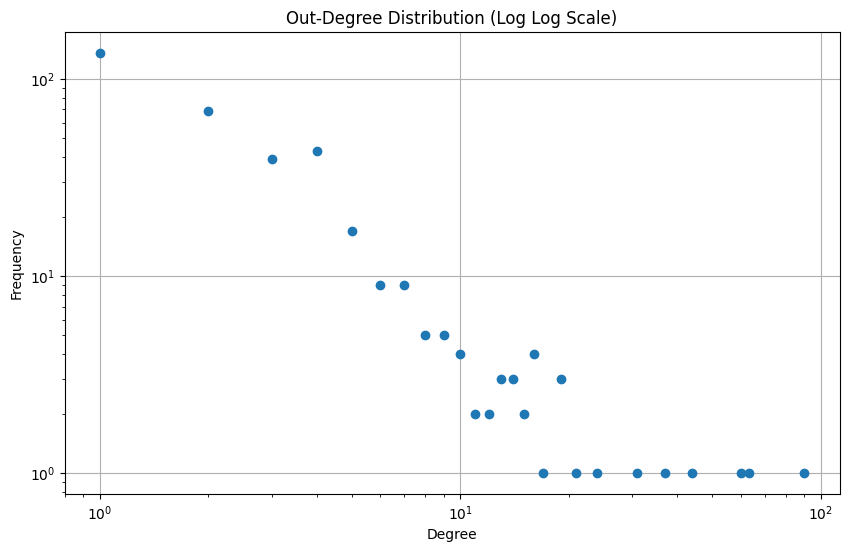

In [15]:
# Plotted the in-degree and out-degree distributions on log-log scale
def plot_degree_distribution_on_log_log_scale(degrees, title):
    # Counting the frequency of each degree value
    degree_counts = np.bincount(list(degrees.values()))

    plt.figure(figsize=(10, 6))
    plt.loglog(range(len(degree_counts)), degree_counts, marker='o', linestyle='None')
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(True)

plot_degree_distribution_on_log_log_scale(in_degrees, 'In-Degree Distribution (Log Log Scale)')
plot_degree_distribution_on_log_log_scale(out_degrees, 'Out-Degree Distribution (Log Log Scale)')
plt.show()

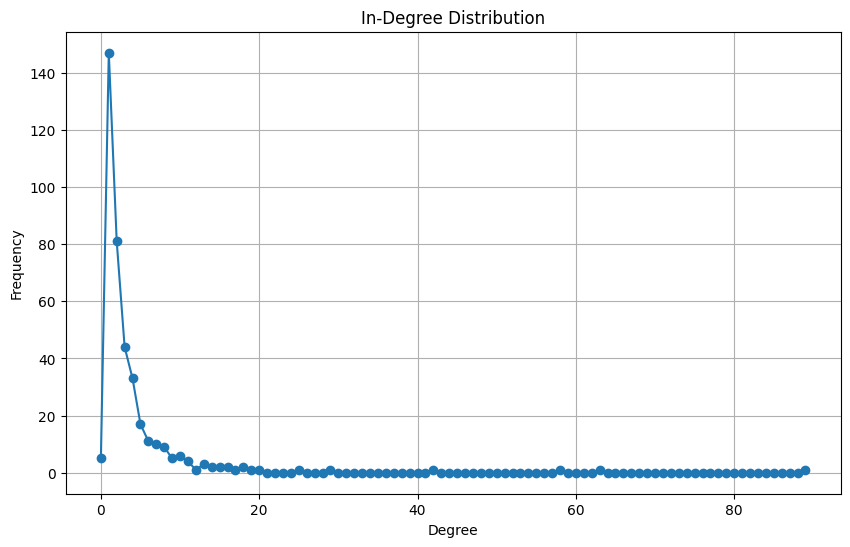

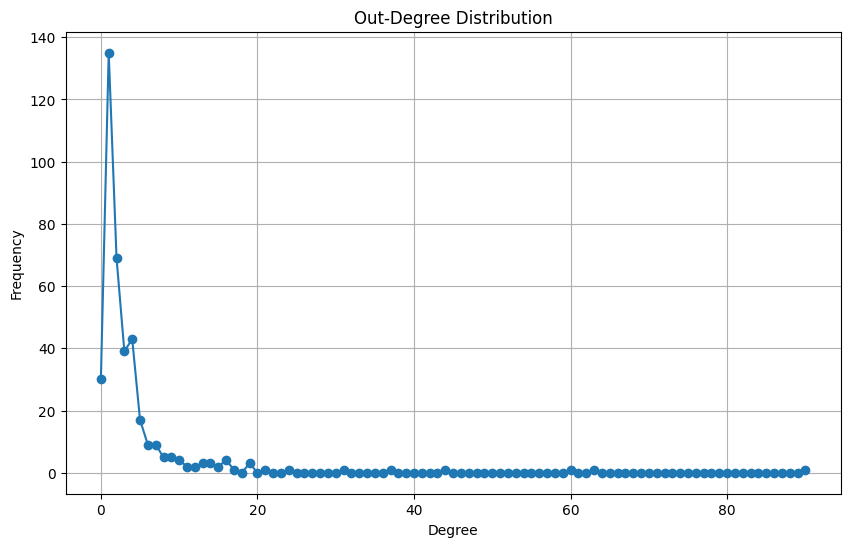

In [16]:
# Plotted the in-degree and out-degree distributions without log-log scale
def plot_degree_distribution(degrees, title):
    # Counted the frequency of each degree value
    degree_counts = np.bincount(list(degrees.values()))
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(degree_counts)), degree_counts, marker='o')
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(True)

plot_degree_distribution(in_degrees, 'In-Degree Distribution')
plot_degree_distribution(out_degrees, 'Out-Degree Distribution')
plt.show()

## Answer 3

To redefine the notion of 'degree' and 'clustering coefficient' for a weighted network to account for the edge weights, we can consider the following adaptations:

1. **Weighted Degree**:
   The weighted degree of a node is defined as the sum of the weights of all edges connected to that node. For an undirected graph, it would be the sum of weights for all incoming and outgoing edges. For a directed graph, there would be a separate calculation for weighted in-degree and weighted out-degree.

2. **Weighted Clustering Coefficient**:
   The clustering coefficient in a weighted network can be adapted to consider the weights of the edges. One approach is to define the strength of a triangle (formed by three interconnected nodes) based on the weights of its edges. For example, the strength of a triangle can be the product of the weights of its three edges. The weighted clustering coefficient for a node would then be the sum of the strengths of all triangles involving that node, normalized by the total possible strength if all its neighbors were interconnected with the highest weights.

These adaptations allow for a more better understanding of the network's structure, taking into account not just the presence of connections, but also their relative strengths or importance.


In [17]:
# Calculated the weighted degree (both in and out) for each node
weighted_in_degrees = {}
weighted_out_degrees = {}

for _, row in data.iterrows():
    source, destination, weight = row['Source'], row['Destination'], row['Weight']

    # Updated weighted out-degree for source
    weighted_out_degrees[source] = weighted_out_degrees.get(source, 0) + weight

    # Updated weighted in-degree for destination
    weighted_in_degrees[destination] = weighted_in_degrees.get(destination, 0) + weight

# Ensured all nodes appear in both weighted in-degrees and out-degrees dictionary
for node in all_nodes:
    weighted_in_degrees.setdefault(node, 0)
    weighted_out_degrees.setdefault(node, 0)

# Calculated weighted degrees (sum of in-degree and out-degree for undirected graphs)
weighted_degrees = {node: weighted_in_degrees[node] + weighted_out_degrees[node] for node in all_nodes}

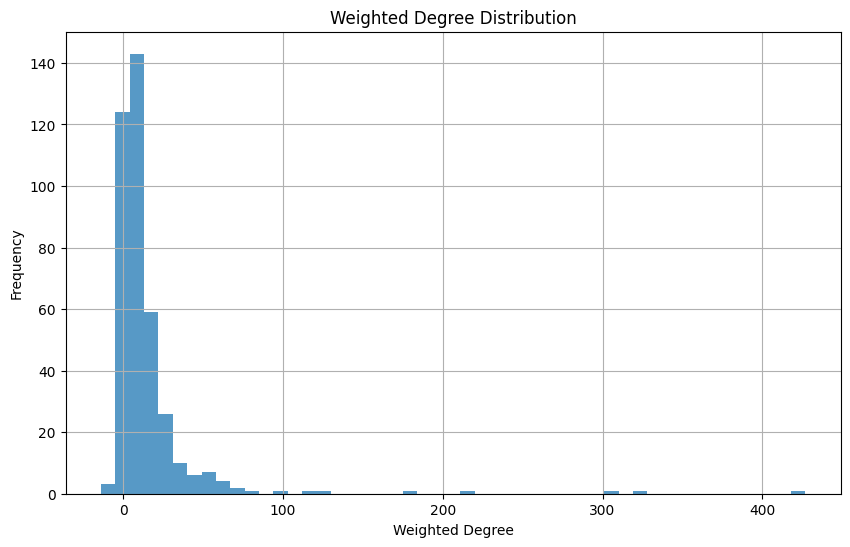

In [18]:
# Adjusted the plot_weighted_degree_distribution function to accommodate floating point values
def plot_weighted_degree_distribution(weighted_degrees, title):
    degree_values = list(weighted_degrees.values())
    
    # Used numpy to create bins with floating point values
    bins = np.linspace(min(degree_values), max(degree_values), 50)  # 50 bins

    plt.figure(figsize=(10, 6))
    plt.hist(degree_values, bins=bins, alpha=0.75)
    plt.title(title)
    plt.xlabel('Weighted Degree')
    plt.ylabel('Frequency')
    plt.grid(True)

plot_weighted_degree_distribution(weighted_degrees, 'Weighted Degree Distribution')

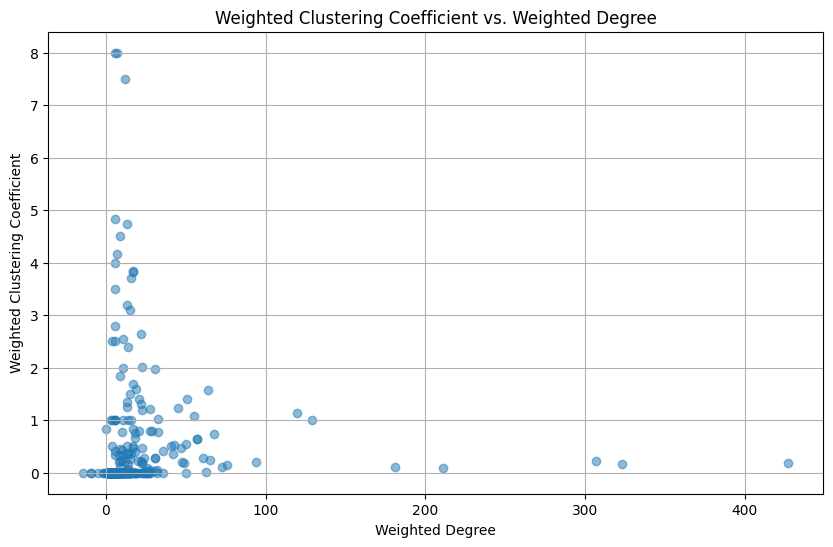

In [19]:
def calculate_weighted_clustering_coefficient(adj_matrix, weights):
    num_nodes = adj_matrix.shape[0]
    weighted_clustering_coefficients = []

    for i in range(num_nodes):
        neighbors = np.nonzero(adj_matrix[i])[0]
        if len(neighbors) < 2:
            weighted_clustering_coefficients.append(0)
        else:
            # Computed the strength of triangles
            triangle_strength = 0
            for u in neighbors:
                for v in neighbors:
                    if u != v and adj_matrix[u, v] > 0:
                        # The strength of the edge is the product of weights
                        triangle_strength += weights[i, u] * weights[i, v] * weights[u, v]

            # Total possible strength
            total_strength = sum([weights[i, u] * weights[i, v] for u in neighbors for v in neighbors if u != v])
            weighted_clustering_coefficients.append(triangle_strength / total_strength if total_strength else 0)

    return weighted_clustering_coefficients

# Computed the weighted clustering coefficient for each node
weighted_clustering_coefficients = calculate_weighted_clustering_coefficient(adjacency_matrix, adjacency_matrix)

# Plotted Clustering Coefficient vs Degree
plt.figure(figsize=(10, 6))
plt.scatter(list(weighted_degrees.values()), weighted_clustering_coefficients, alpha=0.5)
plt.title('Weighted Clustering Coefficient vs. Weighted Degree')
plt.xlabel('Weighted Degree')
plt.ylabel('Weighted Clustering Coefficient')
plt.grid(True)
plt.show()

## Answer 4

In [20]:
# Function to generate a Gilbert random graph
def generate_gilbert_random_graph(n, p):
    # Initialized an adjacency list
    graph = defaultdict(set)
    # Iterated over all possible node pairs and add an edge with probability p
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                graph[i].add(j)
                graph[j].add(i)
    return graph

In [21]:
# Function to calculate degree distribution from the adjacency list
def calculate_degree_distribution(graph):
    degree_distribution = defaultdict(int)
    for node, edges in graph.items():
        degree_distribution[len(edges)] += 1
    return degree_distribution

In [22]:
def plot_all_degree_distributions(degree_distributions):
    num_rows = 20  
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 40), constrained_layout=True)
    fig.suptitle('Degree Distributions of 100 Gilbert Random Graphs')

    for index, distribution in enumerate(degree_distributions):
        ax = axs[index // num_cols, index % num_cols]
        degrees = list(distribution.keys())
        counts = [distribution[degree] for degree in degrees]
        ax.bar(degrees, counts, color='blue', alpha=0.7)
        ax.set_title(f'Graph {index+1}')
        ax.set_xlabel('Degree')
        ax.set_ylabel('Frequency')
        
    for index in range(len(degree_distributions), num_rows * num_cols):
        axs[index // num_cols, index % num_cols].axis('off')
        
    plt.show()

In [23]:
# Function to plot the degree distribution
def plot_degree_distribution(degree_distribution):
    # Converting degree distribution to lists
    degrees = list(degree_distribution.keys())
    counts = list(degree_distribution.values())
    
    # Plot the degree distribution
    plt.bar(degrees, counts, color='blue')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution of the Network')
    plt.show()

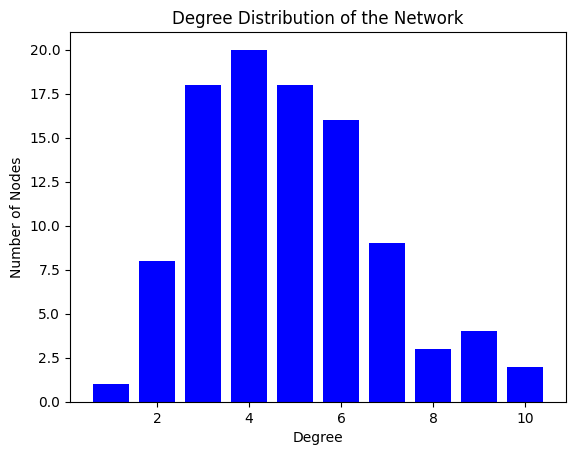

In [24]:
graph = generate_gilbert_random_graph(100, 0.05)
degree_distribution = calculate_degree_distribution(graph)

plot_degree_distribution(degree_distribution)

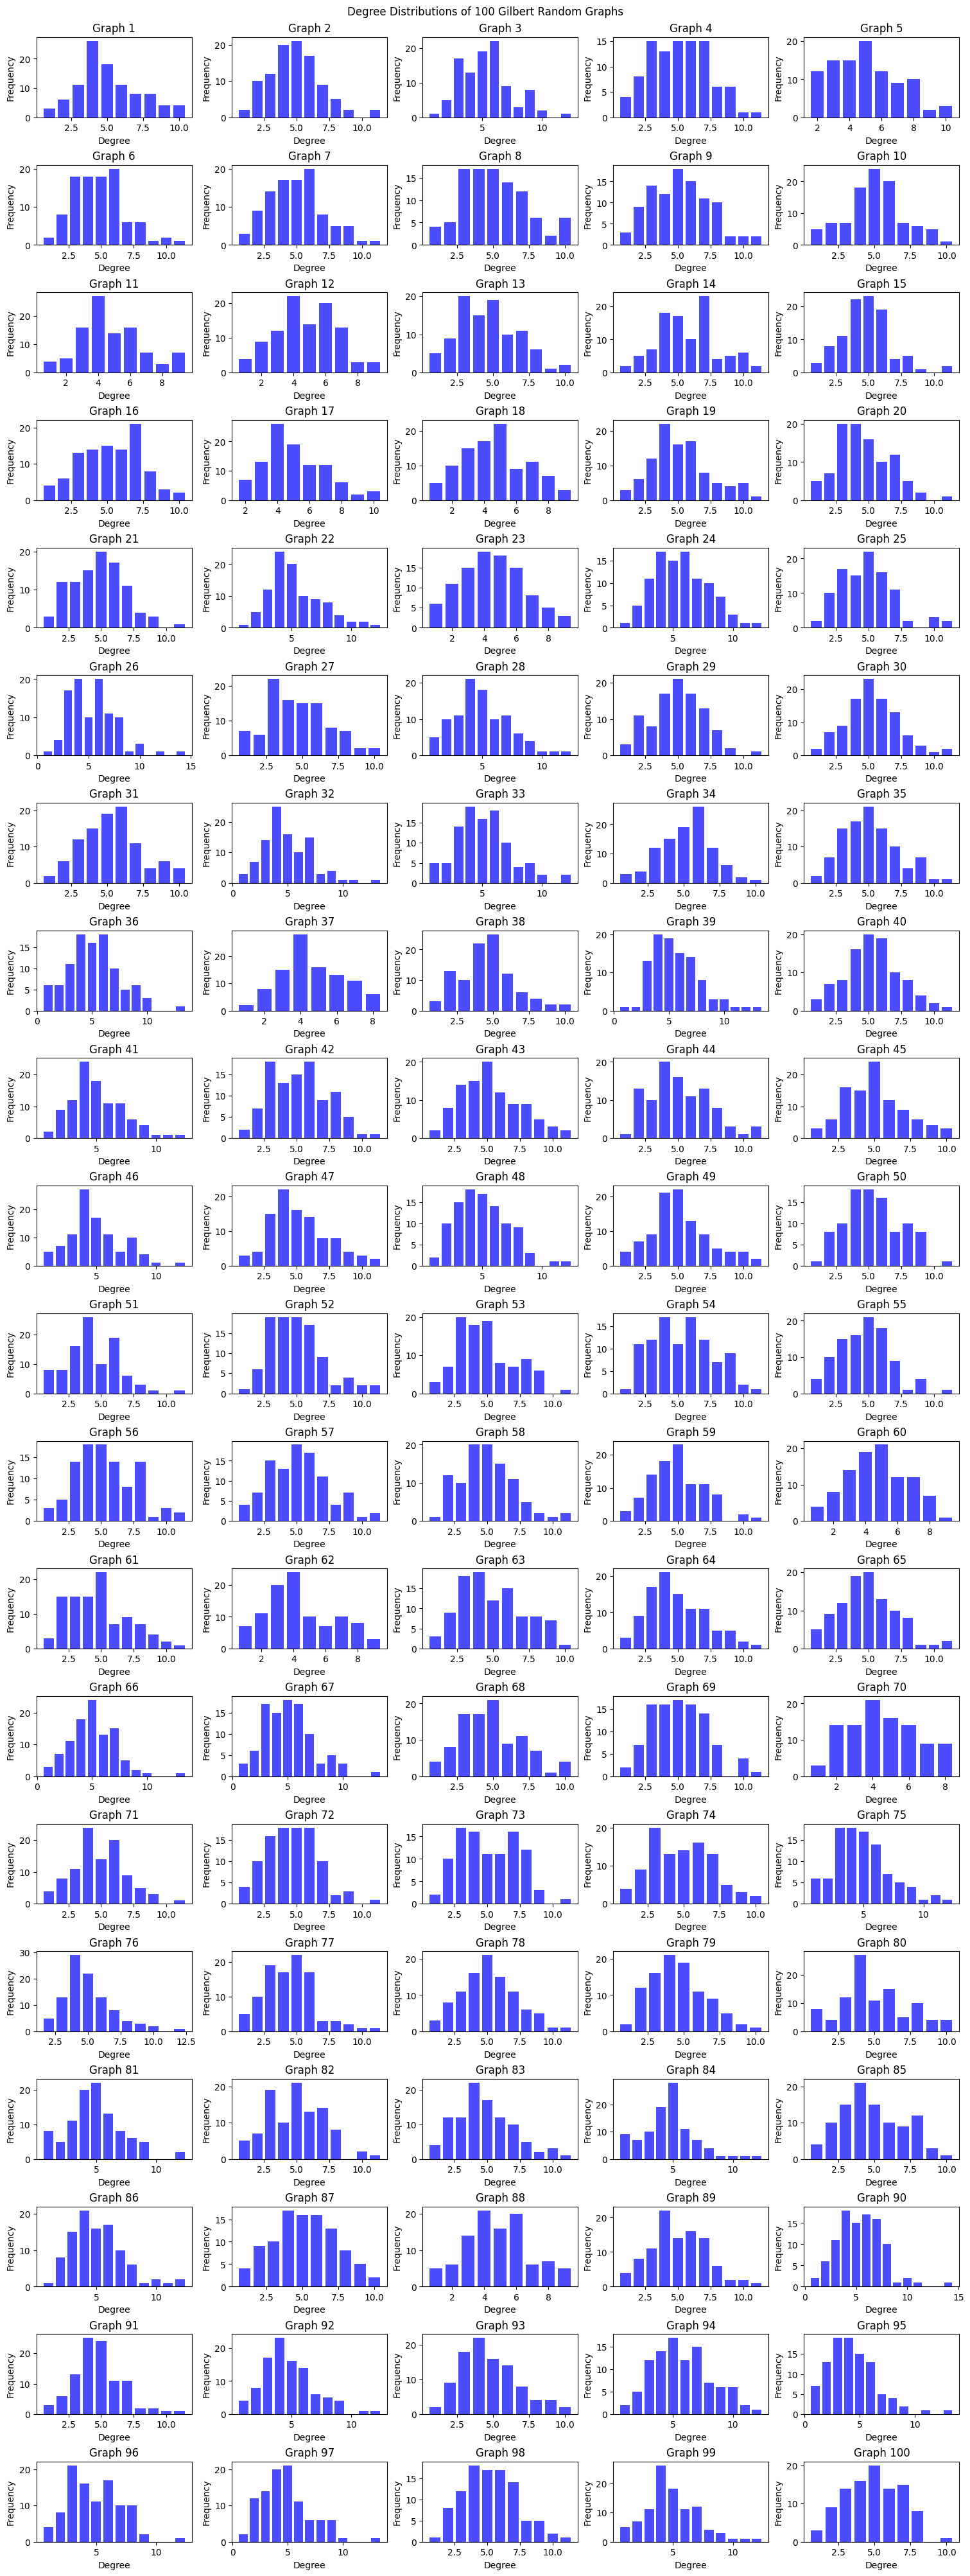

In [25]:
n = 100  # Number of nodes
p = 0.05  # Probability of edge creation
num_instances = 100  
degree_distributions = []

for _ in range(num_instances):
    graph = generate_gilbert_random_graph(n, p)
    degree_distribution = calculate_degree_distribution(graph)
    degree_distributions.append(degree_distribution)

plot_all_degree_distributions(degree_distributions)

### Degree Distribution Comparison

The above represent degree distributions from networks generated by a Gilbert random graph model. Here are the comparative observations:

#### Variability
- Both sets of plots show variability in degree distribution across different graph instances, highlighting the random nature of the Gilbert model.

#### Expected Degree
- The plots indicate a low average degree relative to the network size, suggesting that the networks are sparse, which is consistent with Gilbert random graphs for a relatively small probability `p`.

#### Distribution Shape
- The degree distributions somewhat follow a Poisson distribution. A Power Law kind of distribution is created.

#### Outliers
- There are instances with outliers indicating nodes with significantly higher degrees. These are likely statistical anomalies inherent in the probabilistic graph generation process.
